# **Exploratory data analysis**

In [299]:
import pandas as pd
import string
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
punctuation = string.punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow import keras
from keras.preprocessing import sequence, text
from keras.layers import Input, Embedding
from string import punctuation
import string
punctuation = string.punctuation
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
stop_words = list(set(stopwords.words('english')))
!pip3 install lime
import lime
import lime.lime_tabular

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=b20dad88f2de60e7f04f3bf5b179d3c6867595774d78e0f4d094f0ea63b351f4
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [213]:
train = pd.read_csv(r'training.csv')
validation = pd.read_csv(r'validation.csv')
test = pd.read_csv(r'testing.csv')


In [214]:
# change the column names

train.rename(columns={"Ogling/Facial Expressions/Staring": "Staring", "Touching /Groping": "Touching"}, inplace=True)
validation.rename(columns={"Ogling/Facial Expressions/Staring": "Staring", "Touching /Groping": "Touching"},inplace=True)
test.rename(columns={"Ogling/Facial Expressions/Staring": "Staring", "Touching /Groping": "Touching"},inplace=True)

In [215]:
train.head()

,Description,Commenting,Staring,Touching
0,"Was walking along crowded street, holding mums...",0,0,1
1,This incident took place in the evening.I was ...,0,1,0
2,I WAS WAITING FOR THE BUS. A MAN CAME ON A BIK...,1,0,0
3,Incident happened inside the train,0,0,0
4,I witnessed an incident when a chain was bruta...,0,0,0


In [216]:
train.shape, validation.shape, test.shape

((7201, 4), (990, 4), (1701, 4))

In [217]:
# here we are concatenating train and dev set so that we have more data for training the models
train = pd.concat([train, validation], axis=0 ) # concat train and validation set

In [218]:
# check for null values in the dataset
train.isnull().any()

Description    False
Commenting     False
Staring        False
Touching       False
dtype: bool

In [219]:
# check for null values in the dataset
test.isnull().any()

Description    False
Commenting     False
Staring        False
Touching       False
dtype: bool

In [220]:
# looking for duplicate rows in the train and test set
dup_train = train[train['Description'].duplicated()].shape[0]  # get count of duplicates
dup_test = test[test['Description'].duplicated()].shape[0]

print('Duplicate rows in Train set is ', dup_train)
print('Duplicate rows in Test set  is ', dup_test)

Duplicate rows in Train set is  658
Duplicate rows in Test set  is  93


In [221]:
# keep the first occurance of duplicates for all the datasets and drop the rest

train.drop_duplicates(keep = 'first', inplace=True)
test.drop_duplicates(keep = 'first', inplace=True)

In [222]:
total = train.shape[0]
count = [sum(train.Commenting.values)/total, sum(train['Staring'].values)/total, sum(train['Touching'].values)/total] # count of each Category
label = ['Commenting', 'Staring', 'Touching']  # Categorys

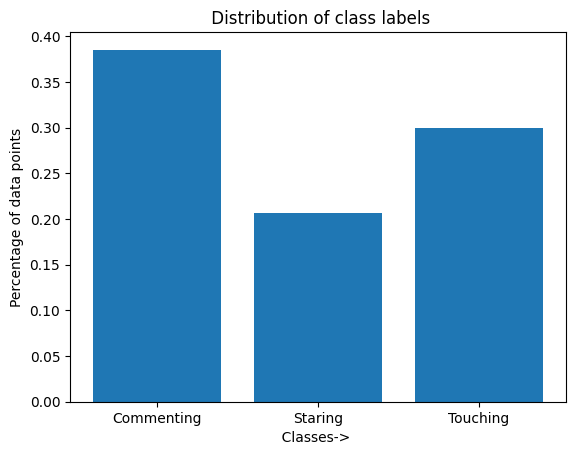

In [223]:
# now let's look at the distribution of the three classes for train set

import matplotlib.pyplot as plt

plt.title(" Distribution of class labels")
plt.xlabel("       Classes->        ")
plt.ylabel("Percentage of data points")
plt.bar(label, count)
plt.show()

In [224]:
# now let's look at the distribution of the three classes in combination with each other
counts_of_class = train[label].sum(axis = 1).value_counts()

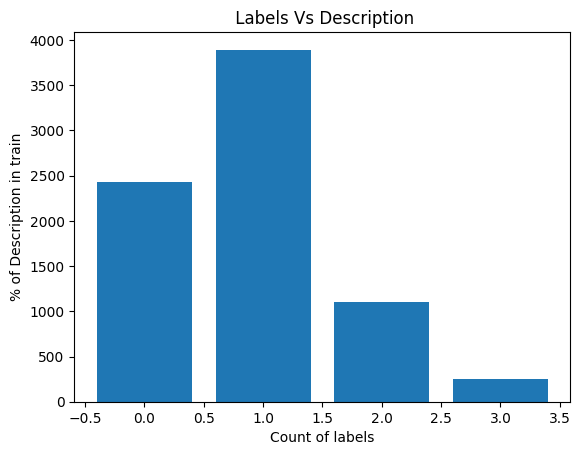

In [225]:
plt.title(" Labels Vs Description")
plt.xlabel("Count of labels")
plt.ylabel("% of Description in train")
plt.bar(counts_of_class.index , counts_of_class.values)
plt.show()

In [226]:
from wordcloud import WordCloud, STOPWORDS

def word_cloud(data, column):
    comment_words = ''
    stopwords = set(STOPWORDS)
    # iterate through the csv file
    for val in data[column]:
	# typecaste each val to string
	    val = str(val)
	# split the value
	    tokens = val.split()
	# Converts each token into lowercase
	    for i in range(len(tokens)):
		    tokens[i] = tokens[i].lower()
	    comment_words += " ".join(tokens)+" "
    wordcloud = WordCloud(width = 500, height = 300,
				background_color ='black',
				stopwords = stopwords,
				min_font_size = 10).generate(comment_words)
    # plot the WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

In [227]:
# now lets look at the most frequent words/unigrams occuring in descriptions having mention of one or more form of sexual harrasment

all_harassment = train[(train['Commenting']==1) | (train['Staring']==1) | (train['Touching']==1)]

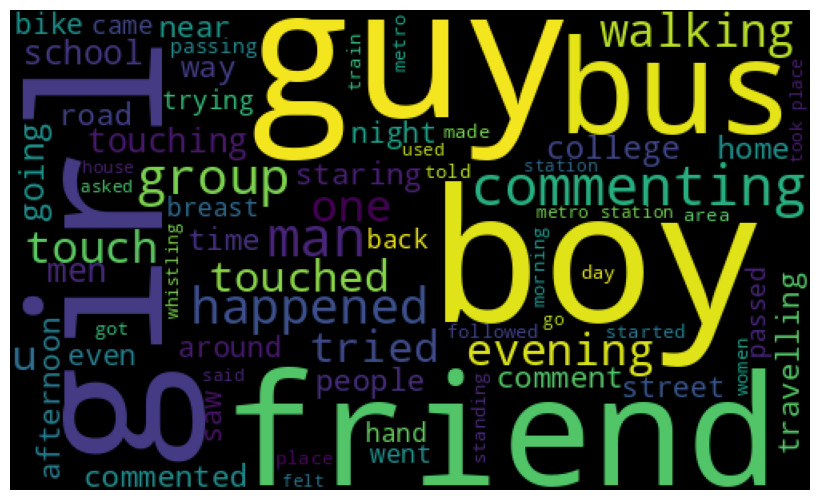

In [228]:
word_cloud(all_harassment, 'Description')

In [229]:
# lets do the same analysis using bi-grams and tri-grams

def word_cloud_ngram(data_frame, column, grams, n, remove_stop=None):
    vec = CountVectorizer(ngram_range=(grams, grams), stop_words=remove_stop).fit(data_frame[column]) # BOW
    bag_of_words = vec.transform(data_frame[column])
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, id]) for word, id in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    words_freq = words_freq[:n]
    d = {i[0].replace(" ", '_'):i[1] for i in words_freq }
    wordcloud = WordCloud(width = 500, height = 300,
				background_color ='black',
				stopwords = stopwords,
				min_font_size = 10).generate_from_frequencies(d)
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

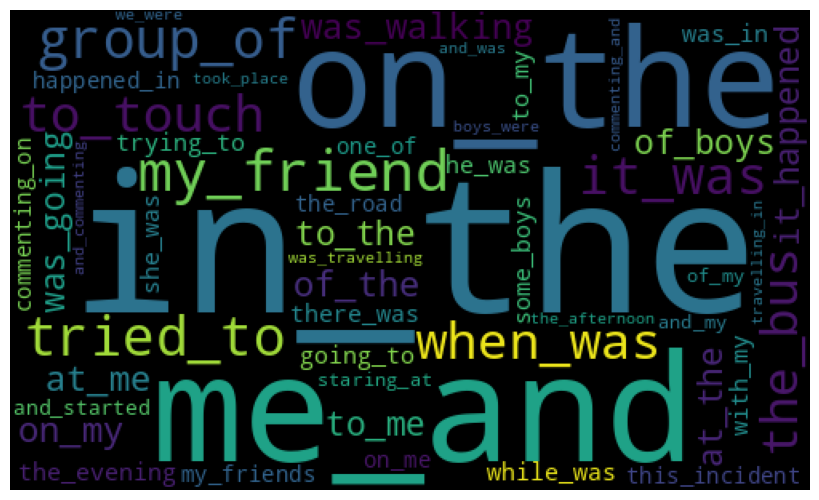

In [230]:
word_cloud_ngram(all_harassment, "Description", 2, 1000)

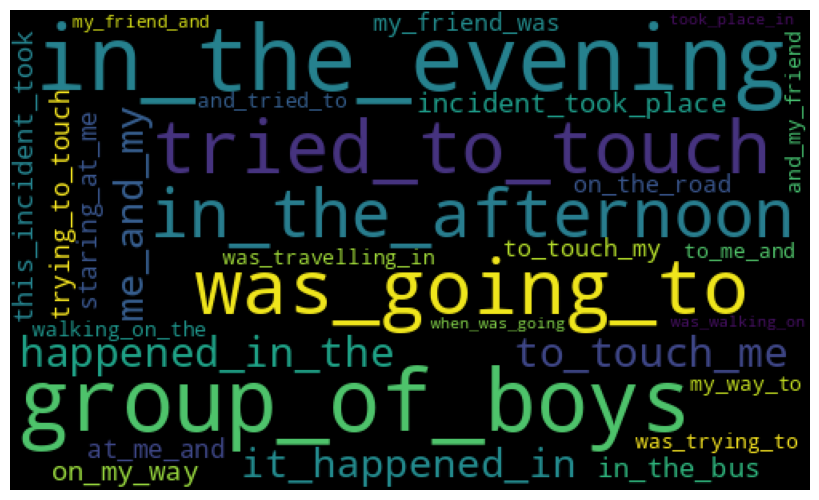

In [231]:
word_cloud_ngram(all_harassment, "Description", 3, 1000)

In [232]:
#feature engineering

def feature_before_preprocessing(data, text_column):
    data['description_len'] = data[text_column].astype(str).apply(len)  # length of the text
    data['word_count'] = data[text_column].apply(lambda x: len(str(x).split()))  # count of words
    data['word_density'] = data['description_len'] / (data['word_count']+1)  # density of description

    data['punctuation_count'] = data[text_column].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) # count of punctuation
    data['title_word_count'] = data[text_column].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()])) # count of title
    data['upper_case_word_count'] = data[text_column].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))  # upper case word count
    data['stopword_count'] = data[text_column].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop_words]))  # count of stopwords
    return data

In [233]:
train = feature_before_preprocessing(train, 'Description')   # get the features
test = feature_before_preprocessing(test, 'Description')
test.head()

,Description,Commenting,Staring,Touching,description_len,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,stopword_count
0,"During morning, a woman was walking by and thi...",1,1,0,151,30,4.870968,4,2,0,13
1,A man tried to brush his penis off of a woman'...,0,0,1,68,15,4.250000,2,1,1,8
2,This happened to a fellow passenger of mine tr...,0,1,0,151,25,5.807692,2,2,0,14
3,ogling,0,1,0,6,1,3.000000,0,0,0,0
4,When I was returning my home after finishing m...,0,0,1,185,40,4.512195,2,3,2,25


In [234]:
# preprocessing

import re
from nltk.stem import WordNetLemmatizer  # lemmatizer
stemmer = WordNetLemmatizer()

def preprocess(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r'\W', ' ', str(text))
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r"[0-9]", "", text)
    text = re.sub(r"[^A-Za-z_]", " ", text)
    text = re.sub(r'[^\w\s]','',text)
    text = ' '.join(e for e in text.split() if e.lower() not in stopwords.words('english') and len(e)>2)
    text = text.lower().strip()

    tokens = text.split()
    tokens = [stemmer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 2]
    new_text = ' '.join(tokens)
    return new_text

In [235]:
# preprocessing the description column
train['Description']= train['Description'].map(lambda a: preprocess(a))
test['Description']= test['Description'].map(lambda a: preprocess(a))

In [236]:
train_text = list(train.Description.values)
test_text = list(test.Description.values)

In [237]:
vect_word = TfidfVectorizer(max_features=5000, analyzer='word', stop_words='english', ngram_range=(1,3), dtype=np.float32)
vect_word.fit(train_text)
tfidf_train = vect_word.transform(train_text)
tfidf_test = vect_word.transform(test_text)

In [238]:
tfidf_word_features = vect_word.get_feature_names_out()

In [239]:
# character
char_word = TfidfVectorizer(max_features=5000, analyzer='char', stop_words='english', ngram_range=(1,4), dtype=np.float32)
char_word.fit(train_text)

# transform
tfidf_train_char = char_word.transform(train_text)
tfidf_test_char = char_word.transform(test_text)

In [240]:
tfidf_char_feature = char_word.get_feature_names_out()

In [241]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

numerical_data = train[['description_len', 'word_count', 'word_density', 'punctuation_count', 'title_word_count', 'upper_case_word_count', 'stopword_count']]
normalizer.fit(numerical_data)    # fit

Normalizer()

In [242]:
column = ['description_len', 'word_count', 'word_density', 'punctuation_count', 'title_word_count', 'upper_case_word_count', 'stopword_count']

train_num = normalizer.transform(train[column])
test_num = normalizer.transform(test[column])

In [243]:
train_text = train['Description']
test_text = test['Description']
all_text = pd.concat([train_text, test_text])

In [244]:
from sklearn.pipeline import make_union

vectorizer = make_union(vect_word, char_word, n_jobs=2)

vectorizer.fit(all_text)
train_features = vectorizer.transform(train_text)
test_features = vectorizer.transform(test_text)

In [245]:
from scipy.sparse import hstack

X_tr_tfidf = hstack((train_num, train_features)).tocsr()
X_te_tfidf = hstack((test_num, test_features)).tocsr()
print(X_tr_tfidf.shape)
print(X_te_tfidf.shape)

(7670, 10007)
(1640, 10007)


In [252]:
from gensim.models.fasttext import FastText
%matplotlib inline

In [253]:
embedding_size = 300  #  size of the embedding vector.
window_size = 20    # size of the number of words occurring before and after the word based on which the word representations.
min_word = 5  # minimum frequency of a word in the corpus for which the word representations will be generated
down_sampling = 1e-2   # most frequently occurring word will be down-sampled by a number specified by the down_sampling

In [254]:
word_punctuation_tokenizer = nltk.WordPunctTokenizer()
word_tokenized_corpus = [word_punctuation_tokenizer.tokenize(sent) for sent in train_text]

In [255]:
ft_model = FastText(word_tokenized_corpus,
                      vector_size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=1,
                      epochs=100)

In [256]:
similar_words = {words: [item[0] for item in ft_model.wv.most_similar([words], topn=5)]
                  for words in ['touch', 'commenting', 'staring', 'road', 'metro']}

for k,v in similar_words.items():
    print(k+":"+str(v))

touch:['trying', 'stomach', 'yatayat', 'try', 'purposely']
commenting:['catcall', 'whistling', 'wistling', 'commented', 'comment']
staring:['continuously', 'wierd', 'karol', 'stared', 'lewd']
road:['cross', 'connecting', 'stretch', 'walking', 'main']
metro:['rajiv', 'station', 'gtb', 'feeder', 'yellow']


In [257]:


from tqdm import tqdm
fasttext_vectors_train = []
for sentence in tqdm(train_text):
    vector = np.zeros(300)
    cnt_words =0
    for word in sentence.split():
        try:
            vec = ft_model.wv[word]
            vector += vec
            cnt_words += 1
        except:
            vec = np.zeros(300)
            vector += vec

    if cnt_words != 0:
        vector /= cnt_words

    fasttext_vectors_train.append(vector)

100%|██████████| 7670/7670 [00:01<00:00, 7524.97it/s]


In [258]:


from tqdm import tqdm
fasttext_vectors_test = []
for sentence in tqdm(test_text):
    vector = np.zeros(300)
    cnt_words =0
    for word in sentence.split():
        try:
            vec = ft_model.wv[word]
            vector += vec
            cnt_words += 1
        except:
            vec = np.zeros(300)
            vector += vec
    if cnt_words != 0:
        vector /= cnt_words

    fasttext_vectors_test.append(vector)

100%|██████████| 1640/1640 [00:00<00:00, 5968.43it/s]


In [259]:
fasttext_vectors_train = np.array(fasttext_vectors_train)
fasttext_vectors_test = np.array(fasttext_vectors_test)

In [260]:
from scipy.sparse import hstack

X_tr_fasttext = np.concatenate([train_num, fasttext_vectors_train], axis=1)
X_te_fasttext = np.concatenate([test_num, fasttext_vectors_test], axis=1)

print("Final Data matrix with fastText representation for description")
print(X_tr_fasttext.shape)
print(X_te_fasttext.shape)
print("="*100)

Final Data matrix with fastText representation for description
(7670, 307)
(1640, 307)


In [261]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot

# number of input columns
n_inputs = X_tr_fasttext.shape[1]   # input shape of the fastText embedded layer


visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(200)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# encoder level 2
e = Dense(100)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# bottleneck
bottleneck = Dense(50)(e)

# decoder, level 1
d = Dense(100)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# decoder level 2
d = Dense(200)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

output = Dense(n_inputs, activation='linear')(d)
model = Model(inputs=visible, outputs=output)
model.compile(optimizer='adam', loss='mse')

In [263]:
history = model.fit(X_tr_fasttext, X_tr_fasttext, epochs=300, batch_size=16, verbose=2, validation_data=(X_te_fasttext, X_te_fasttext))

Epoch 1/300
480/480 - 4s - loss: 0.0304 - val_loss: 0.0130 - 4s/epoch - 9ms/step
Epoch 2/300
480/480 - 2s - loss: 0.0123 - val_loss: 0.0123 - 2s/epoch - 3ms/step
Epoch 3/300
480/480 - 2s - loss: 0.0116 - val_loss: 0.0109 - 2s/epoch - 4ms/step
Epoch 4/300
480/480 - 2s - loss: 0.0109 - val_loss: 0.0107 - 2s/epoch - 3ms/step
Epoch 5/300
480/480 - 2s - loss: 0.0102 - val_loss: 0.0093 - 2s/epoch - 4ms/step
Epoch 6/300
480/480 - 2s - loss: 0.0097 - val_loss: 0.0085 - 2s/epoch - 4ms/step
Epoch 7/300
480/480 - 2s - loss: 0.0091 - val_loss: 0.0081 - 2s/epoch - 4ms/step
Epoch 8/300
480/480 - 2s - loss: 0.0088 - val_loss: 0.0080 - 2s/epoch - 4ms/step
Epoch 9/300
480/480 - 2s - loss: 0.0084 - val_loss: 0.0072 - 2s/epoch - 4ms/step
Epoch 10/300
480/480 - 2s - loss: 0.0081 - val_loss: 0.0071 - 2s/epoch - 3ms/step
Epoch 11/300
480/480 - 2s - loss: 0.0079 - val_loss: 0.0068 - 2s/epoch - 3ms/step
Epoch 12/300
480/480 - 2s - loss: 0.0077 - val_loss: 0.0066 - 2s/epoch - 5ms/step
Epoch 13/300
480/480 - 2s

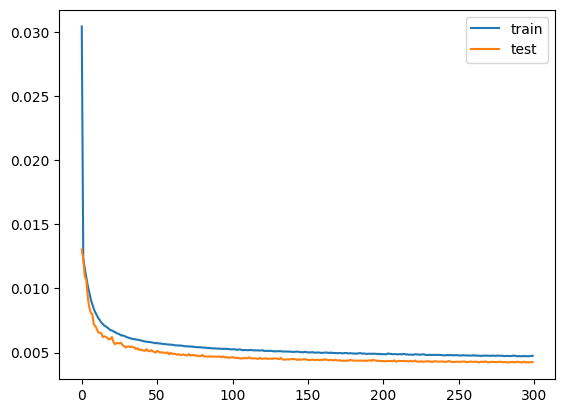

In [264]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [266]:
X_train_encode = encoder.predict(X_tr_fasttext)  # get the compressed features for train and test
X_test_encode = encoder.predict(X_te_fasttext)

52/52 [==============================] - 0s 2ms/step


In [267]:
from scipy.sparse import hstack
X_tr_fasttext_final = np.concatenate([X_tr_fasttext, X_train_encode], axis=1)
X_te_fasttext_final = np.concatenate([X_te_fasttext, X_test_encode], axis=1)
print("Final Data matrix with fastText encoded features representation for description")
print(X_tr_fasttext_final.shape)
print(X_te_fasttext_final.shape)
print("="*100)

Final Data matrix with fastText encoded features representation for description
(7670, 357)
(1640, 357)


In [268]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from scipy import sparse
from datetime import datetime

In [269]:
pip install scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.1 MB/s eta 0:00:00


In [270]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

In [271]:
def exact_match_ratio(y_true, y_pred):
    MR = np.all(y_pred == y_true, axis=1).mean()
    return MR

In [272]:
y_train = train[['Commenting', 'Staring', 'Touching']].values
y_test = test[['Commenting', 'Staring', 'Touching']].values

### Naive Bayes

In [273]:
parameters = [
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.001, 0.05, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 5, 10, 20, 25, 30, 50, 70, 100]
    }]

clf = GridSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=-1, verbose=2)
clf.fit(tfidf_train, y_train)

print (clf.best_params_, clf.best_score_)

Fitting 5 folds for each of 17 candidates, totalling 85 fits
{'classifier': MultinomialNB(alpha=0.2), 'classifier__alpha': 0.2} 0.6457928010809559


In [274]:
classifier = clf.best_estimator_
classifier.fit(tfidf_train, y_train)

BinaryRelevance(classifier=MultinomialNB(alpha=0.2), require_dense=[True, True])

In [275]:
predictions = classifier.predict(tfidf_test)

In [276]:
 print("Hamming Loss: ", hamming_loss(y_test, predictions))
print("Exact Match Ratio: ", exact_match_ratio(y_test, predictions))
print("Recall: ", recall_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Precision: ", precision_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=predictions, average='micro'))

Hamming Loss:  0.1878048780487805
Exact Match Ratio:  0.573170731707317
Recall:  0.5405767940979208
Precision:  0.7712918660287081
Fl score:  0.6356466876971608


In [277]:
parameters = [
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.001, 0.05, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 5, 10, 20, 25, 30, 50, 70, 100]
    }]

clf = GridSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=-1, verbose=2)
clf.fit(tfidf_train_char, y_train)

print (clf.best_params_, clf.best_score_)

Fitting 5 folds for each of 17 candidates, totalling 85 fits
{'classifier': MultinomialNB(alpha=0.1), 'classifier__alpha': 0.1} 0.6437764696962833


In [278]:
classifier = clf.best_estimator_
classifier.fit(tfidf_train_char, y_train)

BinaryRelevance(classifier=MultinomialNB(alpha=0.1), require_dense=[True, True])

In [279]:
predictions = classifier.predict(tfidf_test_char)

In [280]:
print("Hamming Loss: ", hamming_loss(y_test, predictions))
print("Exact Match Ratio: ", exact_match_ratio(y_test, predictions))
print("Recall: ", recall_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Precision: ", precision_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=predictions, average='micro'))

Hamming Loss:  0.19654471544715446
Exact Match Ratio:  0.5542682926829269
Recall:  0.562709590878605
Precision:  0.7270363951473137
Fl score:  0.6344045368620037


In [281]:
parameters = [
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.001, 0.05, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 5, 10, 20, 25, 30, 50, 70, 100]
    }]

clf = GridSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=-1, verbose=2)
clf.fit(X_tr_tfidf, y_train)

print (clf.best_params_, clf.best_score_)

Fitting 5 folds for each of 17 candidates, totalling 85 fits
{'classifier': MultinomialNB(alpha=0.4), 'classifier__alpha': 0.4} 0.6731618312771946


In [282]:
classifier = clf.best_estimator_
classifier.fit(X_tr_tfidf, y_train)

BinaryRelevance(classifier=MultinomialNB(alpha=0.4), require_dense=[True, True])

In [283]:
predictions = classifier.predict(X_te_tfidf)

In [284]:
print("Hamming Loss: ", hamming_loss(y_test, predictions))
print("Exact Match Ratio: ", exact_match_ratio(y_test, predictions))
print("Recall: ", recall_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Precision: ", precision_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=predictions, average='micro'))

Hamming Loss:  0.19329268292682927
Exact Match Ratio:  0.5646341463414634
Recall:  0.6217303822937625
Precision:  0.7054794520547946
Fl score:  0.6609625668449197


In [286]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hamming loss", "F1 score", "Precision", "Recall", "Exact Match Ratio"]
x.add_row(["tf-idf (word)", 'Multinomial Naive Bayes', 0.1873, 0.6370, 0.7712, 0.5425, 0.5737])
x.add_row(["tf-idf (character)", 'Multinomial Naive Bayes', 0.1939, 0.6413, 0.7296, 0.5720,  0.5603])
x.add_row(["tf-idf (word + character)", 'Multinomial Naive Bayes', 0.1926, 0.6626, 0.7058, 0.6244, 0.5646])

In [287]:
print(x)

+---------------------------+-------------------------+--------------+----------+-----------+--------+-------------------+
|         Vectorizer        |          Model          | Hamming loss | F1 score | Precision | Recall | Exact Match Ratio |
+---------------------------+-------------------------+--------------+----------+-----------+--------+-------------------+
|       tf-idf (word)       | Multinomial Naive Bayes |    0.1873    |  0.637   |   0.7712  | 0.5425 |       0.5737      |
|     tf-idf (character)    | Multinomial Naive Bayes |    0.1939    |  0.6413  |   0.7296  | 0.572  |       0.5603      |
| tf-idf (word + character) | Multinomial Naive Bayes |    0.1926    |  0.6626  |   0.7058  | 0.6244 |       0.5646      |
+---------------------------+-------------------------+--------------+----------+-----------+--------+-------------------+


### Logistic regression

In [288]:
parameters = [
    {
        'classifier': [LogisticRegression()],
        "classifier__C":[0.001, 0.01, 0.1, 1, 10, 100],
        "classifier__penalty":['l2'],
        "classifier__solver":["newton-cg", "lbfgs", "liblinear", "sag"]

    }]

clf = GridSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=-1,verbose=2)
clf.fit(tfidf_train, y_train)

print (clf.best_params_, clf.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'classifier': LogisticRegression(C=10, solver='newton-cg'), 'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'} 0.6597865794215497


In [289]:
classifier = clf.best_estimator_
classifier.fit(tfidf_train, y_train)

BinaryRelevance(classifier=LogisticRegression(C=10, solver='newton-cg'),
                require_dense=[True, True])

In [290]:
predictions = classifier.predict(tfidf_test)

In [291]:
print("Hamming Loss: ", hamming_loss(y_test, predictions))
print("Exact Match Ratio: ", exact_match_ratio(y_test, predictions))
print("Recall: ", recall_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Precision: ", precision_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=predictions, average='micro'))

Hamming Loss:  0.1806910569105691
Exact Match Ratio:  0.5829268292682926
Recall:  0.5848423876592891
Precision:  0.7635726795096323
Fl score:  0.6623623243448539


In [292]:
parameters = [
    {
        'classifier': [LogisticRegression()],
        "classifier__C":[0.001, 0.01, 0.1, 1, 10, 100],
        "classifier__penalty":['l2'],
        "classifier__solver":["newton-cg", "lbfgs", "liblinear", "sag"]

    }]

clf = GridSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=-1,verbose=2)
clf.fit(tfidf_train_char, y_train)

print (clf.best_params_, clf.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'classifier': LogisticRegression(C=10, solver='liblinear'), 'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'} 0.6669568707802522


In [293]:
classifier = clf.best_estimator_
classifier.fit(tfidf_train_char, y_train)

BinaryRelevance(classifier=LogisticRegression(C=10, solver='liblinear'),
                require_dense=[True, True])

In [294]:
predictions = classifier.predict(tfidf_test_char)

In [295]:
print("Hamming Loss: ", hamming_loss(y_test, predictions))
print("Exact Match Ratio: ", exact_match_ratio(y_test, predictions))
print("Recall: ", recall_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Precision: ", precision_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=predictions, average='micro'))

Hamming Loss:  0.17154471544715447
Exact Match Ratio:  0.6140243902439024
Recall:  0.5814889336016097
Precision:  0.797608095676173
Fl score:  0.6726144297905353


In [297]:
parameters = [
    {
        'classifier': [LogisticRegression()],
        "classifier__C":[0.001, 0.01, 0.1, 1, 10, 100],
        "classifier__penalty":['l2'],
        "classifier__solver":["newton-cg", "lbfgs", "liblinear", "sag"]

    }]

clf = GridSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=-1,verbose=2)
clf.fit(X_tr_tfidf, y_train)

print (clf.best_params_, clf.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


KeyboardInterrupt: 

In [ ]:
classifier = clf.best_estimator_
classifier.fit(X_tr_tfidf, y_train)

In [ ]:
predictions = classifier.predict(X_te_tfidf)

In [ ]:
print("Hamming Loss: ", hamming_loss(y_test, predictions))
print("Exact Match Ratio: ", exact_match_ratio(y_test, predictions))
print("Recall: ", recall_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Precision: ", precision_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=predictions, average='micro'))

In [ ]:
parameters = [
    {
        'classifier': [LogisticRegression()],
        "classifier__C":[0.001, 0.01, 0.1, 1, 10, 100],
        "classifier__penalty":['l2'],
        "classifier__solver":["newton-cg", "lbfgs", "liblinear", "sag"]

    }]

clf = GridSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=-1,verbose=2)
clf.fit(X_tr_tfidf_w2v, y_train)

print (clf.best_params_, clf.best_score_)

In [ ]:
classifier = clf.best_estimator_
classifier.fit(X_tr_tfidf_w2v, y_train)

In [ ]:
predictions = classifier.predict(X_te_tfidf_w2v)

In [ ]:
print("Hamming Loss: ", hamming_loss(y_test, predictions))
print("Exact Match Ratio: ", exact_match_ratio(y_test, predictions))
print("Recall: ", recall_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Precision: ", precision_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=predictions, average='micro'))

In [ ]:
parameters = [
    {
        'classifier': [LogisticRegression()],
        "classifier__C":[0.001, 0.01, 0.1, 1, 10, 100],
        "classifier__penalty":['l2'],
        "classifier__solver":["newton-cg", "lbfgs", "liblinear", "sag"]

    }]

clf = GridSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=-1,verbose=2)
clf.fit(X_tr_fasttext_final, y_train)

print(clf.best_params_, clf.best_score_)


In [ ]:
classifier = clf.best_estimator_
classifier.fit(X_tr_fasttext_final, y_train)

In [ ]:
predictions = classifier.predict(X_te_fasttext_final)

In [ ]:
print("Hamming Loss: ", hamming_loss(y_test, predictions))
print("Exact Match Ratio: ", exact_match_ratio(y_test, predictions))
print("Recall: ", recall_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Precision: ", precision_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=predictions, average='micro'))

In [ ]:
y = PrettyTable()
y.field_names = ["Vectorizer","Model","Hamming loss","F1 score","Precision","Recall","EMR"]
y.add_row(["tf-idf(word)",'Logistic Regression',0.1794,0.6648,0.7657,0.5875,0.5865])
y.add_row(["tf-idf(character)",'Logistic Regression',0.1794,0.6648,0.7657,0.5875,0.5865])
y.add_row(["tf-idf(word+character)",'Logistic Regression',0.1619,0.6758,0.8584,0.5573,0.6323])
y.add_row(["tf-idf w2v + Numerical",'Logistic Regression',0.2006,0.6024,0.7540,0.5016,0.5524])
y.add_row(["fastText + Autoencoded + ### Report XGBoost ClassifierNumerical",'Logistic Regression',0.1853,0.6337,0.7897,0.5291,0.5853])

In [ ]:
print(y)

### Support Vector Machine (classifier)

In [ ]:
parameters = [
    {
        'classifier': [SVC()],
        'classifier__C': [50, 10, 1.0, 0.1]
    }
    ]

clf = GridSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=-1, verbose=2)
clf.fit(tfidf_train, y_train)

print(clf.best_params_, clf.best_score_)

In [ ]:
classifier = clf.best_estimator_
classifier.fit(tfidf_train, y_train)

In [ ]:
predictions = classifier.predict(tfidf_test)

In [ ]:
print("Hamming Loss: ", hamming_loss(y_test, predictions))
print("Exact Match Ratio: ", exact_match_ratio(y_test, predictions))
print("Recall: ", recall_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Precision: ", precision_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=predictions, average='micro'))

In [ ]:
parameters = [
    {
        'classifier': [SVC()],
        'classifier__C': [50, 10, 1.0, 0.1],
        'classifier__kernel':['poly', 'rbf']
    }
    ]

clf = GridSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=-1,verbose=2)
clf.fit(tfidf_train_char, y_train)

print (clf.best_params_, clf.best_score_)

In [ ]:
classifier = clf.best_estimator_
classifier.fit(tfidf_train_char, y_train)

In [ ]:
predictions = classifier.predict(tfidf_test_char)

In [ ]:
print("Hamming Loss: ", hamming_loss(y_test, predictions))
print("Exact Match Ratio: ", exact_match_ratio(y_test, predictions))
print("Recall: ", recall_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Precision: ", precision_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=predictions, average='micro'))

In [ ]:
parameters = [
    {
        'classifier': [SVC()],
        'classifier__C': [50, 10, 1.0, 0.1, 0.01],
        'classifier__kernel':['poly', 'rbf']
    }
    ]

clf = GridSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=-1,verbose=2)
clf.fit(X_tr_tfidf, y_train)

print (clf.best_params_, clf.best_score_)


In [ ]:
classifier = clf.best_estimator_
classifier.fit(X_tr_tfidf, y_train)

In [ ]:
predictions = classifier.predict(X_te_tfidf)

In [ ]:
print("Hamming Loss: ", hamming_loss(y_test, predictions))
print("Exact Match Ratio: ", exact_match_ratio(y_test, predictions))
print("Recall: ", recall_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Precision: ", precision_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=predictions, average='micro'))

In [ ]:
parameters = [
    {
        'classifier': [SVC()],
        'classifier__C': [50, 10, 1.0, 0.1, 0.01],
        'classifier__kernel':['poly', 'rbf']
    }
    ]

clf = GridSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=6,verbose=2)
clf.fit(X_tr_tfidf_w2v, y_train)

print (clf.best_params_, clf.best_score_)


In [ ]:
classifier = clf.best_estimator_
classifier.fit(X_tr_tfidf_w2v, y_train)

In [ ]:
predictions = classifier.predict(X_te_tfidf_w2v)

In [ ]:
print("Hamming Loss: ", hamming_loss(y_test, predictions))
print("Exact Match Ratio: ", exact_match_ratio(y_test, predictions))
print("Recall: ", recall_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Precision: ", precision_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=predictions, average='micro'))

In [ ]:
parameters = [
    {
        'classifier': [SVC()],
        'classifier__C': [50, 10, 1.0, 0.1, 0.01],
        'classifier__kernel':['poly', 'rbf']
    }
    ]

clf = GridSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=-1,verbose=2)
clf.fit(X_tr_fasttext_final, y_train)

print (clf.best_params_, clf.best_score_)


In [ ]:
classifier = clf.best_estimator_
classifier.fit(X_tr_fasttext_final, y_train)

In [ ]:
predictions = classifier.predict(X_te_fasttext_final)

In [ ]:
print("Hamming Loss: ", hamming_loss(y_test, predictions))
print("Exact Match Ratio: ", exact_match_ratio(y_test, predictions))
print("Recall: ", recall_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Precision: ", precision_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=predictions, average='micro'))

In [ ]:
y = PrettyTable()
y.field_names = ["Vectorizer","Model","Hamming loss","F1 score","Precision","Recall","EMR"]
y.add_row(["tf-idf(word)",'SVM',0.1766,0.6648,0.7822,0.5781,0.6024])
y.add_row(["tf-idf(character)",'SVM',0.1636, 0.6919, 0.8057, 0.6063, 0.6317])
y.add_row(["tf-idf(word+character)",'SVM',0.1689, 0.6858, 0.7859, 0.6083, 0.6158])
y.add_row(["tf-idf w2v + Numerical",'SVM',0.1963, 0.6111, 0.7643, 0.5090, 0.5640])
y.add_row(["fastText + Autoencoded + Numerical",'SVM',0.1833, 0.6549, 0.7622, 0.5741, 0.5853])

In [ ]:
print(y)

### Random Forest

In [ ]:
parameters = [
        {'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [10, 100, 1000],
        'classifier__max_features' : ['sqrt', 'log2']
        }
]

clf = GridSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=6, verbose=2)
clf.fit(tfidf_train, y_train)

print(clf.best_params_, clf.best_score_)

In [ ]:
classifier = clf.best_estimator_
classifier.fit(tfidf_train, y_train)

In [ ]:
predictions = classifier.predict(tfidf_test)

In [ ]:
print("Hamming Loss: ", hamming_loss(y_test, predictions))
print("Exact Match Ratio: ", exact_match_ratio(y_test, predictions))
print("Recall: ", recall_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Precision: ", precision_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=predictions, average='micro'))

In [ ]:
parameters = [
        {'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [10, 100, 1000],
        'classifier__max_features' : ['sqrt', 'log2']
        }
    ]

clf = GridSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=6, verbose=2)
clf.fit(tfidf_train_char, y_train)

print(clf.best_params_, clf.best_score_)

In [ ]:
classifier = clf.best_estimator_
classifier.fit(tfidf_train_char, y_train)

In [ ]:
predictions = classifier.predict(tfidf_test_char)

In [ ]:
print("Hamming Loss: ", hamming_loss(y_test, predictions))
print("Exact Match Ratio: ", exact_match_ratio(y_test, predictions))
print("Recall: ", recall_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Precision: ", precision_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=predictions, average='micro'))

In [ ]:
parameters = [
        {'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [500 ,1000, 1500],
        'classifier__max_features' : ['sqrt', 'log2']
        }
    ]

clf = GridSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=6, verbose=2)
clf.fit(X_tr_tfidf, y_train)

print(clf.best_params_, clf.best_score_)

In [ ]:
classifier = clf.best_estimator_
classifier.fit(X_tr_tfidf, y_train)

In [ ]:
predictions = classifier.predict(X_te_tfidf)

In [ ]:
print("Hamming Loss: ", hamming_loss(y_test, predictions))
print("Exact Match Ratio: ", exact_match_ratio(y_test, predictions))
print("Recall: ", recall_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Precision: ", precision_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=predictions, average='micro'))

In [ ]:
parameters = [
        {'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [500, 1000, 1200],
        'classifier__max_features' : ['sqrt']
        }
    ]

clf = GridSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=6, verbose=2)
clf.fit(X_tr_tfidf_w2v, y_train)

print(clf.best_params_, clf.best_score_)

In [ ]:
classifier = clf.best_estimator_
classifier.fit(X_tr_tfidf_w2v, y_train)

In [ ]:
predictions = classifier.predict(X_te_tfidf_w2v)

In [ ]:
print("Hamming Loss: ", hamming_loss(y_test, predictions))
print("Exact Match Ratio: ", exact_match_ratio(y_test, predictions))
print("Recall: ", recall_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Precision: ", precision_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=predictions, average='micro'))

In [ ]:
parameters = [
        {'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [1000, 1200, 1500],
        'classifier__max_features' : ['sqrt']
        }
    ]

clf = GridSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=6, verbose=2)
clf.fit(X_tr_fasttext_final, y_train)

print(clf.best_params_, clf.best_score_)

In [ ]:
classifier = clf.best_estimator_
classifier.fit(X_tr_fasttext_final, y_train)

In [ ]:
predictions = classifier.predict(X_te_fasttext_final)

In [ ]:
print("Hamming Loss: ", hamming_loss(y_test, predictions))
print("Exact Match Ratio: ", exact_match_ratio(y_test, predictions))
print("Recall: ", recall_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Precision: ", precision_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=predictions, average='micro'))

In [ ]:
y = PrettyTable()
y.field_names = ["Vectorizer","Model","Hamming loss","F1 score","Precision","Recall","EMR"]
y.add_row(["tf-idf(word)",'Random Forest',0.1684, 0.6807, 0.7992, 0.5928, 0.6219])
y.add_row(["tf-idf(character)",'Random Forest',0.1636, 0.6752, 0.8471, 0.5613, 0.6304])
y.add_row(["tf-idf(word+character)",'Random Forest',0.1632, 0.6747, 0.8517, 0.5586, 0.6292])
y.add_row(["tf-idf w2v + Numerical",'Random Forest',0.2172, 0.5204, 0.7859, 0.3890, 0.5079])
y.add_row(["fastText + Autoencoded + Numerical",'Random Forest',0.2079,0.5511,0.7969,0.4211,0.5341])

In [ ]:
print(y)

## XGBoost

In [ ]:
from xgboost import XGBClassifier
parameters = [
          {
            'classifier': [XGBClassifier()],
            'classifier__learning_rate' :[0.001, 0.01, 0.1],
            'classifier__n_estimators':[10, 100, 250, 500, 1000, 2000],
            'classifier__subsample': [0.5, 0.7, 1.0],
            'classifier__max_depth': [3, 7, 9]
          }
        ]

clf = RandomizedSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=6, verbose=2)
clf.fit(X_tr_tfidf_w2v, y_train)

print(clf.best_params_, clf.best_score_)

In [ ]:
classifier = clf.best_estimator_
classifier.fit(X_tr_tfidf_w2v, y_train)

In [ ]:
predictions = classifier.predict(X_te_tfidf_w2v)

In [ ]:
print("Hamming Loss: ", hamming_loss(y_test, predictions))
print("Exact Match Ratio: ", exact_match_ratio(y_test, predictions))
print("Recall: ", recall_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Precision: ", precision_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=predictions, average='micro'))

In [ ]:
from xgboost import XGBClassifier
parameters = [
          {
            'classifier': [XGBClassifier()],
            'classifier__learning_rate' :[0.01, 0.1],
            'classifier__n_estimators':[500, 1000, 2000],
            'classifier__subsample': [0.5, 0.7],
            'classifier__max_depth': [3, 7, 9]
          }
        ]

clf = RandomizedSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=-1, verbose=2)
clf.fit(X_tr_fasttext_final, y_train)

print(clf.best_params_, clf.best_score_)

In [ ]:
classifier = clf.best_estimator_
classifier.fit(X_tr_fasttext_final, y_train)

In [ ]:
predictions = classifier.predict(X_te_fasttext_final)

In [ ]:
print("XGBoost with 'fastText embedded words + Autoencoded features + numerical features' featurization")
print(50*"*")
print("Hamming Loss: ", hamming_loss(y_test, predictions))
print("Exact Match Ratio: ", exact_match_ratio(y_test, predictions))
print("Recall: ", recall_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Precision: ", precision_score(y_true=y_test, y_pred=predictions, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=predictions, average='micro'))

In [ ]:
y = PrettyTable()
y.field_names = ["Vectorizer","Model","Hamming loss","F1 score","Precision","Recall","EMR"]
y.add_row(["tf-idf w2v + Numerical",'XGBoost classifier',0.2056, 0.6068, 0.7211, 0.5238, 0.5408])
y.add_row(["fastText + Autoencoded + Numerical",'XGBoost classifier',0.1841, 0.6562, 0.7554, 0.5801, 0.5908])

In [ ]:
print(y)

In [ ]:

from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hamming loss", "F1 score", "Precision", "Recall", "Exact Match Ratio"]
x.add_row(["tf-idf (word)", 'Multinomial Naive Bayes', 0.1873, 0.6370, 0.7712, 0.5425, 0.5737])
x.add_row(["tf-idf(word+character)",'Logistic Regression',0.1619,0.6758,0.8584,0.5573,0.6323])
x.add_row(["tf-idf(character)",'SVM',0.1636, 0.6919, 0.8057, 0.6063, 0.6317])
x.add_row(["tf-idf(word+character)",'Random Forest',0.1632, 0.6747, 0.8517, 0.5586, 0.6292])
x.add_row(["fastText + Autoencoded + Numerical",'XGBoost classifier',0.1841, 0.6562, 0.7554, 0.5801, 0.5908])
print(x)